In [100]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

import skimage
import skimage.measure
import matplotlib.patches as mpatches

from scipy import ndimage
from skimage import morphology, util, filters

import tifffile as tiffio

import ipywidgets as widgets
from IPython.display import display

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [94]:
frames = pims.ImageSequence('/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_2/stokes/1120/mid_pH_test_125min_1/Pos2/*.tif')
stakeframe = pims.open('/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_2/stokes/1120/stack.jpg')

In [95]:
len(frames)

525

In [4]:
# only want the bf frame
bf_frames = frames[::3]
bf_frames[1]
len(bf_frames)

175

In [5]:
def play_frames(frame_index):
    plt.imshow(bf_frames[frame_index], cmap='gray')
    plt.axis('off')
    plt.show()

frame_slider = widgets.IntSlider(min=0, max=len(bf_frames)-1, step=1, value=0)
widgets.interact(play_frames, frame_index=frame_slider)


interactive(children=(IntSlider(value=0, description='frame_index', max=174), Output()), _dom_classes=('widget…

<function __main__.play_frames(frame_index)>

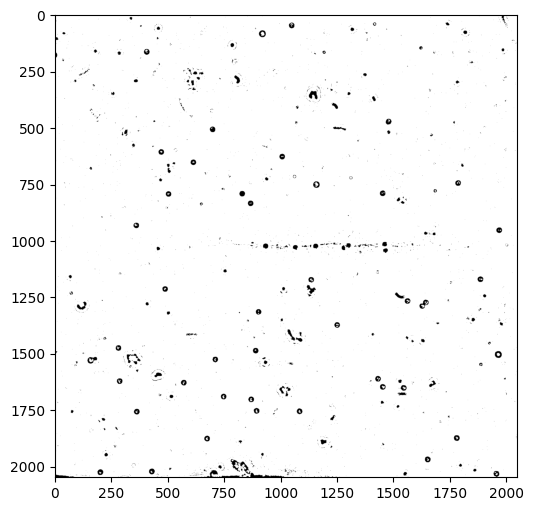

In [70]:
@pims.pipeline
def preprocess_foam(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    # Apply thresholds
    adaptive_thresh = filters.threshold_local(img,101)
    idx = img < adaptive_thresh
    idx2 = img > adaptive_thresh
    img[idx] = 0
    img[idx2] = 255
    img = ndimage.binary_dilation(img)
    img = ndimage.binary_dilation(img)
    return util.img_as_int(img)


frames_thresh = preprocess_foam(bf_frames)
plt.imshow(frames_thresh[20]);

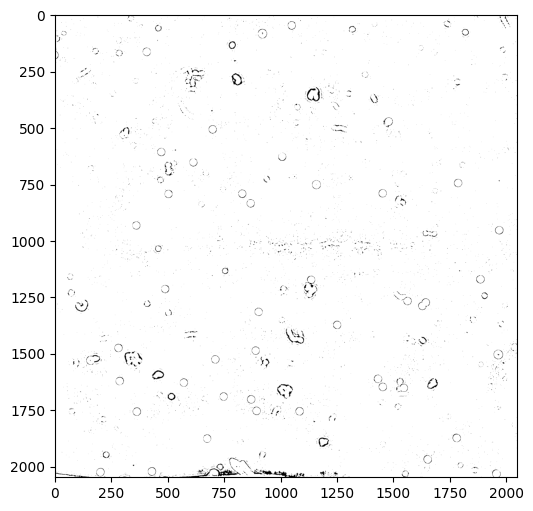

In [63]:
from skimage import filters, util
from scipy import ndimage
import pims

@pims.pipeline
def preprocess_foam(img, block_size=501, less_dark_threshold=1):
    """
    Apply image processing functions to return a binary image.
    
    Parameters:
    img: The input image.
    block_size: The size of the neighborhood used for the local threshold.
    less_dark_threshold: Factor to adjust the adaptive threshold for less dark features.
    """
    # Crop the pictures as for raw images.
    # Apply thresholds
    adaptive_thresh = filters.threshold_local(img, block_size)
    
    # Here we adjust the threshold to be slightly more lenient on dark features.
    # Multiplying by less_dark_threshold (should be > 1) will make the threshold higher,
    # meaning that more pixels will be considered 'dark' and fewer 'light'.
    adaptive_thresh *= less_dark_threshold
    
    idx = img < adaptive_thresh
    idx2 = img >= adaptive_thresh
    img[idx] = 255
    img[idx2] = 0
    
    # Dilations can be adjusted or removed as per the requirement
    img = ndimage.binary_dilation(img, iterations=2)
    
    return util.img_as_int(img)
frames_thresh = preprocess_foam(bf_frames)
plt.imshow(frames_thresh[20]);

Found 2792 features


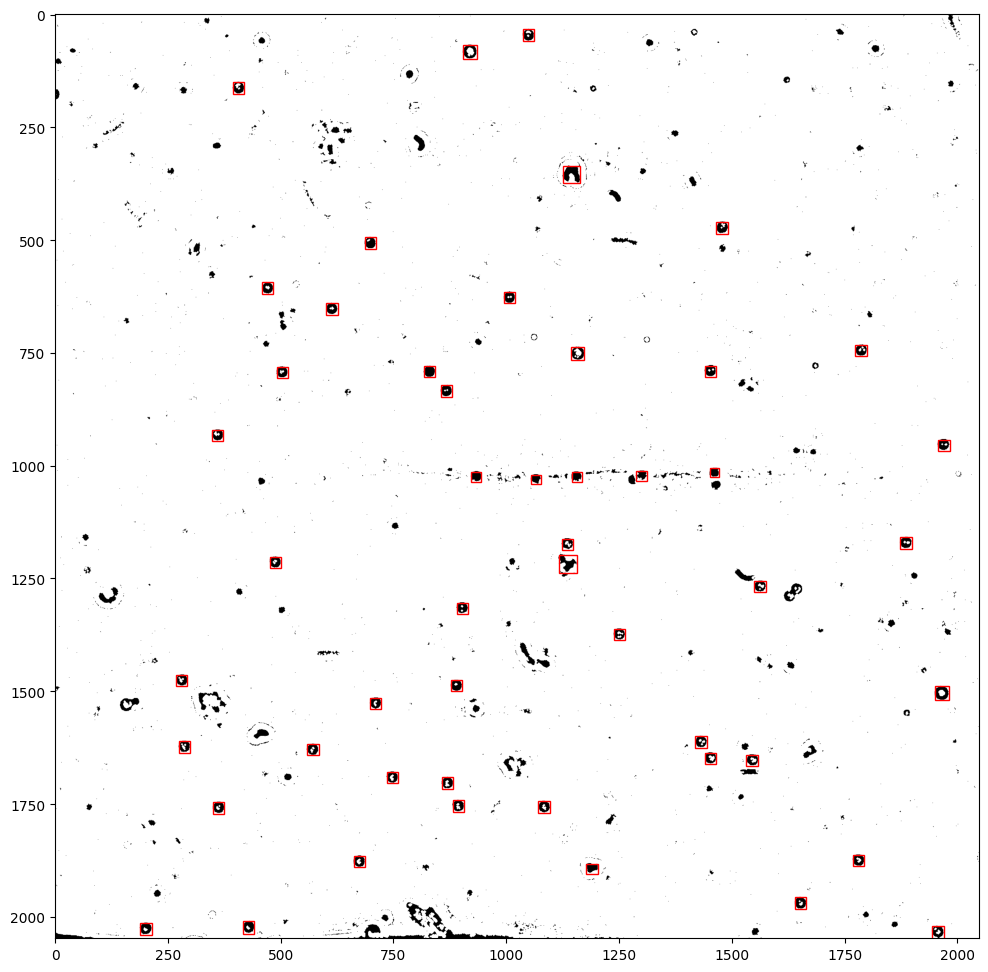

In [76]:
img_example = frames_thresh[20]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
    if region.area < 300 or region.area > 1200:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
    if region.centroid[0] > 1200 and region.area < 300:
        continue
    # Skip non-rounded features using eccentricity
    max_eccentricity = 0.8  # Adjust this threshold as needed
    if region.eccentricity > max_eccentricity:
        continue

    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [77]:

def filter_regions(num, img):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    regions = skimage.measure.regionprops(label_image, intensity_image=img)

    filtered_regions = [
        {
            'y': region.centroid[0],
            'x': region.centroid[1],
            'frame': num
        }
        for region in regions
        if (
            300 <= region.area <= 1200 and
            region.mean_intensity <= 1 and
            not (region.centroid[0] > 1200 and region.area < 300) and
            region.eccentricity <= 0.8
        )
    ]

    return filtered_regions


filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])


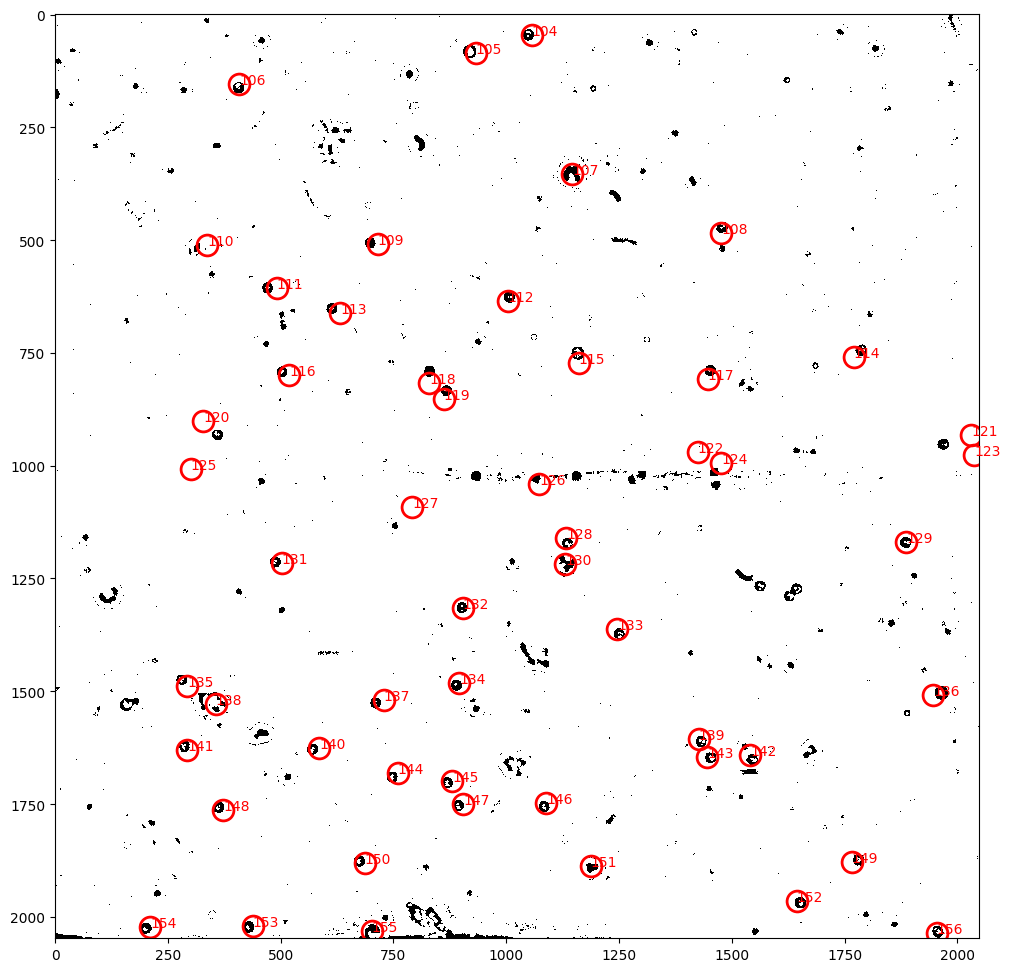

In [78]:
def plot_features_with_labels(frame, features_df, image):
    """
    This function annotates each detected feature with its ID on the plot.

    Parameters:
    frame: The number of the frame you want to plot.
    features_df: A pandas DataFrame that contains the features detected by trackpy.
    image: The image you want to plot the features on.
    """
    # Create a new DataFrame that only contains the features in the frame you're interested in
    frame_features = features_df[features_df.frame==frame]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    tp.annotate(frame_features, image, ax=ax)
    
    # Annotate the ID of each feature
    for index, feature in frame_features.iterrows():
        ax.text(feature.x, feature.y, str(index), color='red')

    plt.show()


# Then you would use it like this:
id_example = 1
plot_features_with_labels(id_example+1, features, img_example)

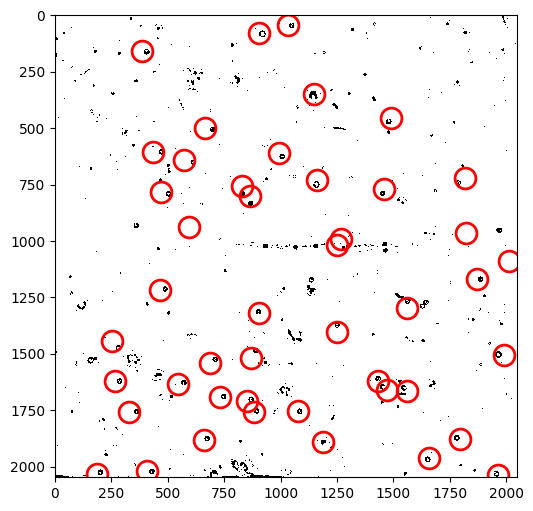

In [79]:
id_example = 50
tp.annotate(features[features.frame==(id_example+1)], img_example);


Frame 174: 50 trajectories present.


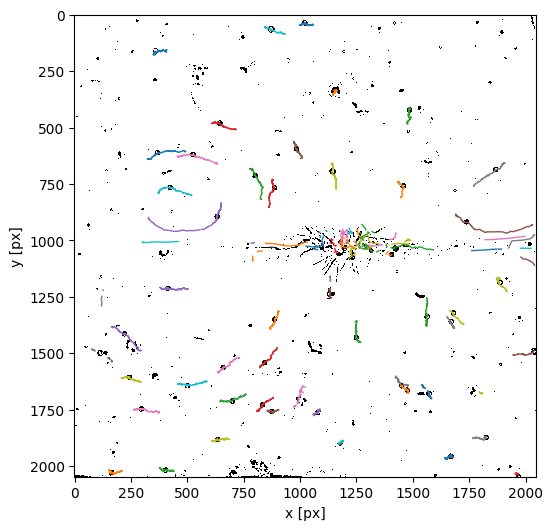

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [86]:
search_range = 60
t = tp.link_df(features, search_range, memory=60)
tp.plot_traj(t, superimpose=frames_thresh[100])

In [81]:
# convert data type
gray = bf_frames[174].astype('float32')

# shift pixel intensity by a constant
intensity_shift = -1200
gray += intensity_shift

# another option is to use a factor value > 1:
# gray *= factor_intensity

# clip pixel intensity to be in range [0, 255]
gray = np.clip(gray, 0, 255)

# change type back to 'uint8'
gray = gray.astype('uint8')

Frame([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
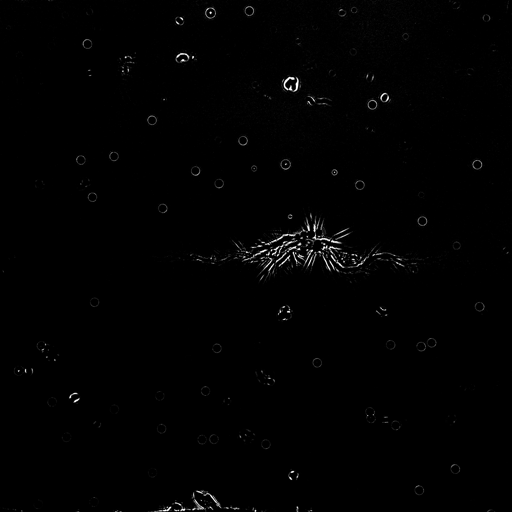

In [82]:
gray

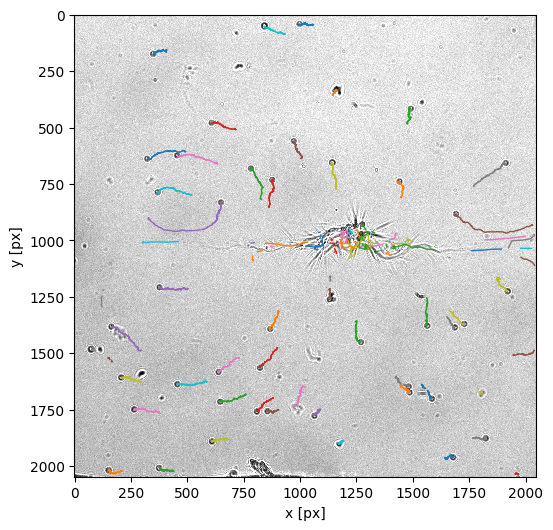

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [96]:
tp.plot_traj(t, superimpose=stakeframe[0])


Frame([[234, 238, 236, ..., 219, 241, 232],
       [237, 224, 210, ..., 219, 203, 234],
       [199, 231, 235, ..., 201, 198, 216],
       ...,
       [ 50,  56,  52, ..., 192, 200, 213],
       [ 62,  55,  45, ..., 193, 196, 190],
       [ 56,  45,  55, ..., 211, 183, 199]], dtype=uint8)
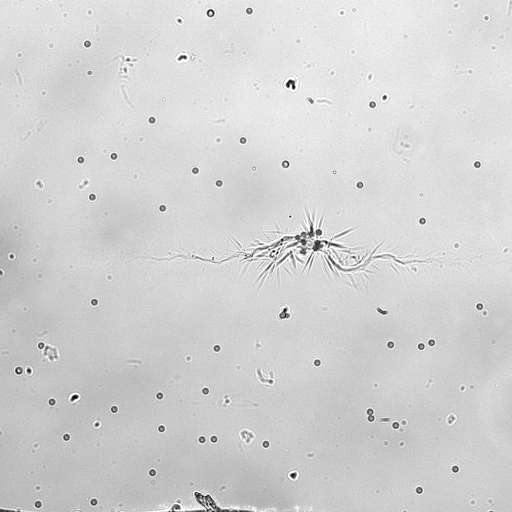

In [97]:
stakeframe[0]

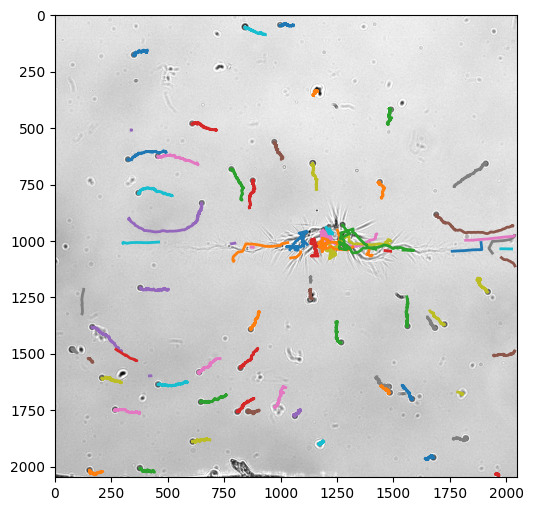

In [98]:
grouped = t.groupby('particle')
plt.imshow(stakeframe[0], cmap='gray')

for name, group in grouped:
    plt.plot(group['x'], group['y'], linewidth=2)

plt.show()

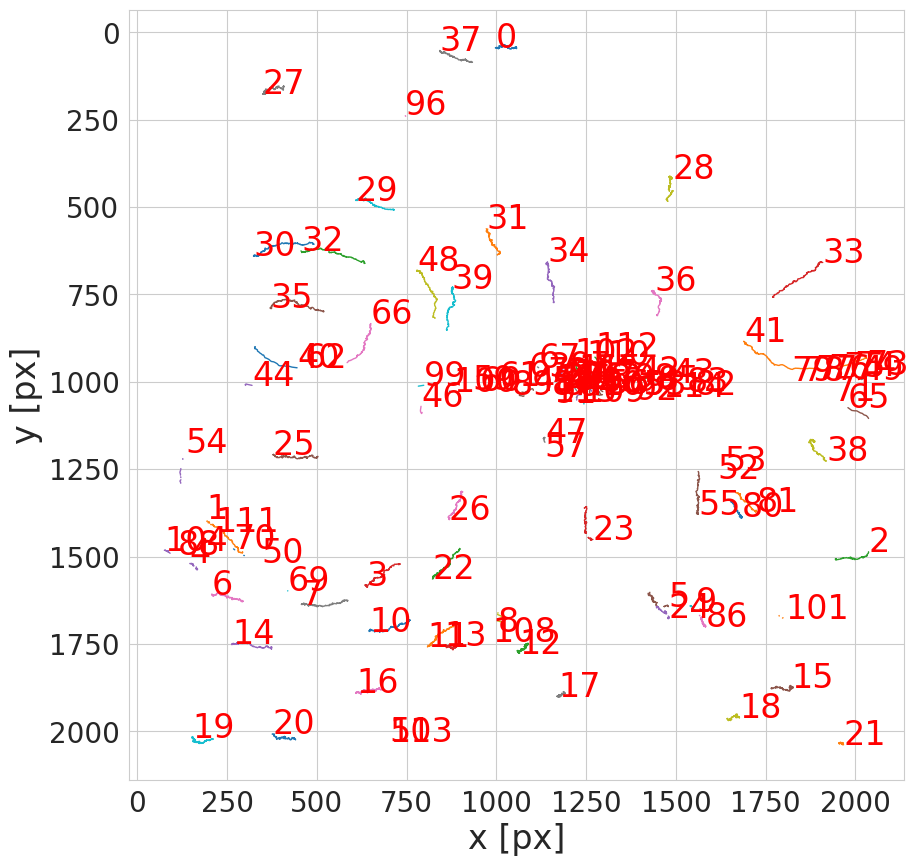

In [36]:
def plot_trajectory_with_labels(particles_df):
    """
    This function plots the trajectories of particles and annotates each one with its ID.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    tp.plot_traj(particles_df, ax=ax)

    # Get the last position of each particle to place the text
    last_positions = particles_df.groupby('particle').last()

    # Annotate the ID of each particle
    for particle, position in last_positions.iterrows():
        ax.text(position.x, position.y, str(int(particle)), color='red')

    plt.show()

# Then you would use it like this:
plot_trajectory_with_labels(t)


## Dont need

In [214]:
t

,y,x,frame,particle
0,39.830065,1315.479303,0,0
27,1263.023207,619.559072,0,1
28,1268.819820,1673.768018,0,2
29,1271.351293,935.280172,0,3
30,1281.640860,467.152688,0,4
...,...,...,...,...
8337,961.933962,119.426887,174,62
8338,1031.435323,1071.161692,174,110
8339,1068.629956,547.453744,174,107
8341,1188.639640,312.123874,174,4


/tmp/ipykernel_792916/1751616529.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


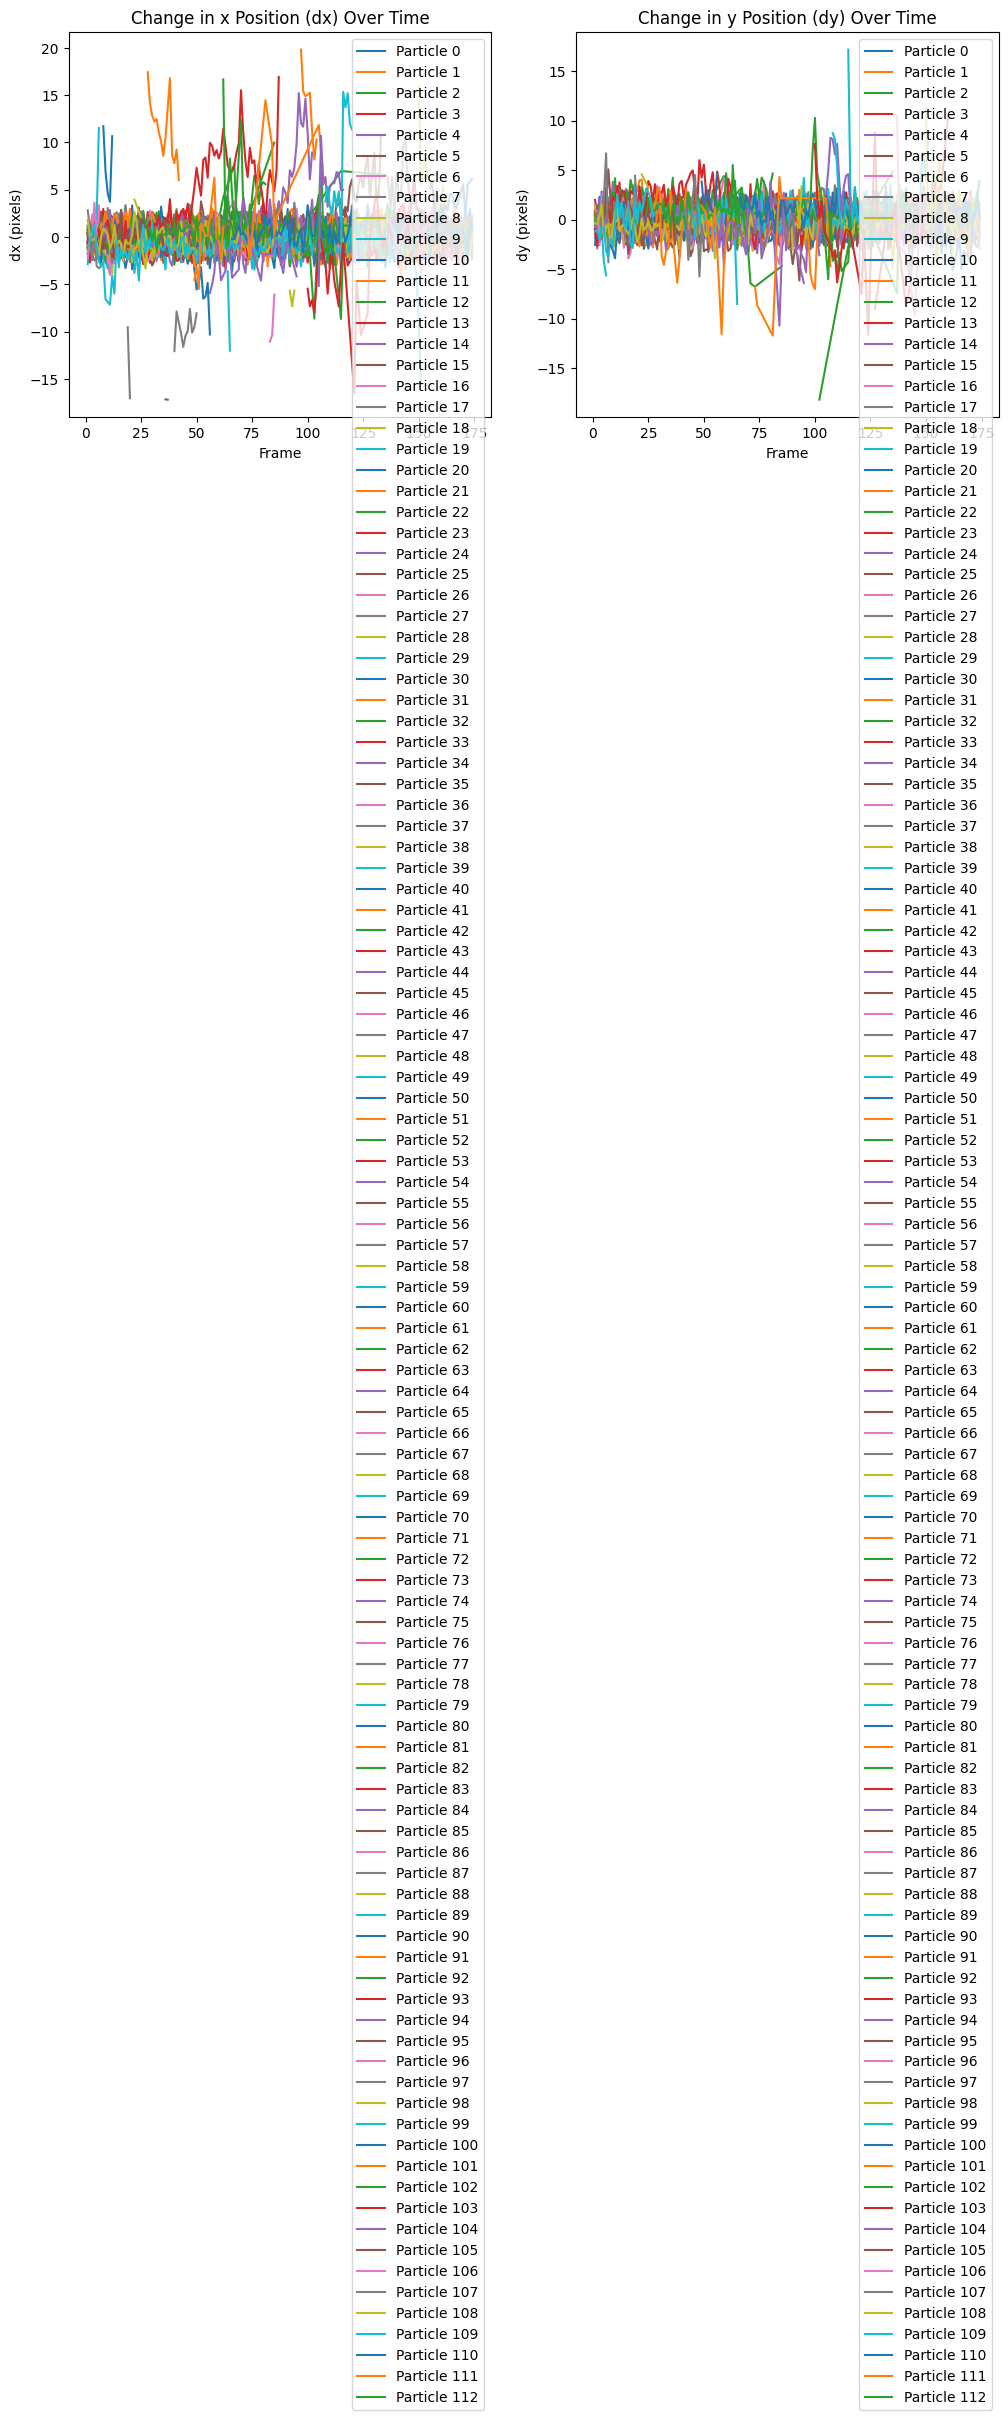

                y            x  frame  particle  displacement_um  \
0       39.830065  1315.479303      0         0              NaN   
27    1263.023207   619.559072      0         1              NaN   
28    1268.819820  1673.768018      0         2              NaN   
29    1271.351293   935.280172      0         3              NaN   
30    1281.640860   467.152688      0         4              NaN   
...           ...          ...    ...       ...              ...   
8337   961.933962   119.426887    174        62         0.932698   
8338  1031.435323  1071.161692    174       110         3.122457   
8339  1068.629956   547.453744    174       107         1.225398   
8341  1188.639640   312.123874    174         4         0.109379   
8364  2015.843011  1849.008602    174        21         0.126568   

      velocity_um_per_s  
0                   NaN  
27                  NaN  
28                  NaN  
29                  NaN  
30                  NaN  
...                 ...  
8

In [215]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample DataFrame 't' (replace this with your actual DataFrame)
# t = pd.DataFrame(....)

# Constants for conversion
pixel_to_um = 0.43  # 1 pixel = 0.43 um
time_diff = 10  # Time difference between frames in seconds

# Calculate displacement
t['dx'] = t.groupby('particle')['x'].diff()  # Change in x
t['dy'] = t.groupby('particle')['y'].diff()  # Change in y
t['displacement_pixels'] = np.sqrt(t['dx']**2 + t['dy']**2)

# Convert displacement to micrometers (um)
t['displacement_um'] = t['displacement_pixels'] * pixel_to_um

# Calculate velocity in um/s
t['velocity_um_per_s'] = t['displacement_um'] / time_diff

# Plot dx and dy for each particle
plt.figure(figsize=(12, 5))

# Plot for dx
plt.subplot(1, 2, 1)
for particle in t['particle'].unique():
    plt.plot(t[t['particle'] == particle]['frame'], t[t['particle'] == particle]['dx'], label=f"Particle {particle}")
plt.xlabel('Frame')
plt.ylabel('dx (pixels)')
plt.title('Change in x Position (dx) Over Time')
plt.legend()

# Plot for dy
plt.subplot(1, 2, 2)
for particle in t['particle'].unique():
    plt.plot(t[t['particle'] == particle]['frame'], t[t['particle'] == particle]['dy'], label=f"Particle {particle}")
plt.xlabel('Frame')
plt.ylabel('dy (pixels)')
plt.title('Change in y Position (dy) Over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Drop intermediate calculation columns
t.drop(['dx', 'dy', 'displacement_pixels'], axis=1, inplace=True)

# Display the final DataFrame
print(t)


In [216]:
t = tp.filter_stubs(t, 10)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t['particle'].nunique())

Before: 62
After: 62


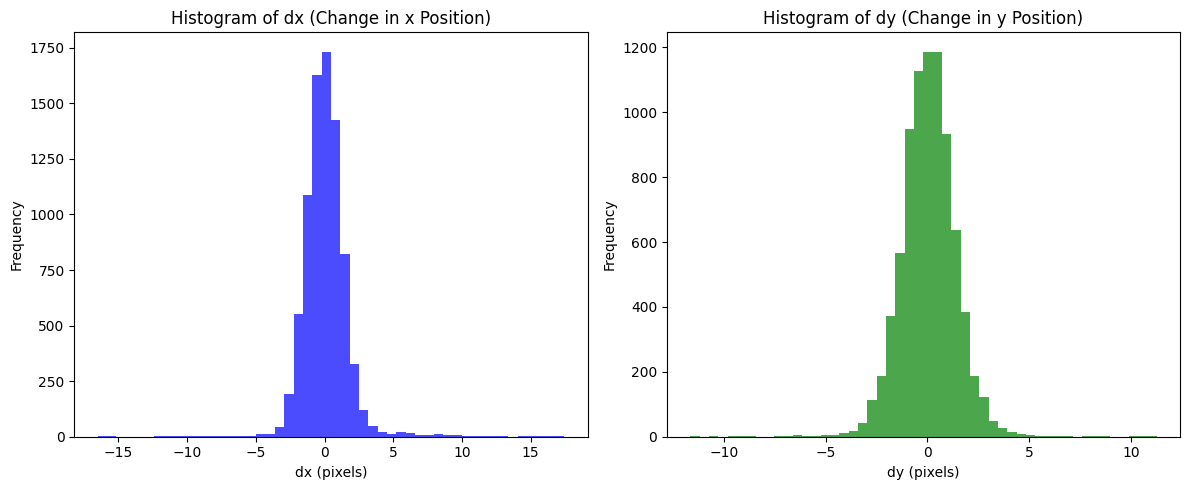

In [217]:
# Constants for conversion
pixel_to_um = 0.43  # 1 pixel = 0.43 um
time_diff = 10  # Time difference between frames in seconds

# Calculate displacement
t['dx'] = t.groupby('particle')['x'].diff()  # Change in x
t['dy'] = t.groupby('particle')['y'].diff()  # Change in y

# Create histograms for dx and dy
plt.figure(figsize=(12, 5))

# Histogram for dx
plt.subplot(1, 2, 1)
plt.hist(t['dx'].dropna(), bins=50, color='blue', alpha=0.7)
plt.xlabel('dx (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram of dx (Change in x Position)')

# Histogram for dy
plt.subplot(1, 2, 2)
plt.hist(t['dy'].dropna(), bins=50, color='green', alpha=0.7)
plt.xlabel('dy (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram of dy (Change in y Position)')

plt.tight_layout()
plt.show()


In [218]:
# Constants for conversion
pixel_to_um = 0.43  # 1 pixel = 0.43 um
time_diff = 10  # Time difference between frames in seconds

# Calculate displacement
t['dx'] = t.groupby('particle')['x'].diff().fillna(0)  # Change in x
t['dy'] = t.groupby('particle')['y'].diff().fillna(0)  # Change in y

# Filter out small displacements
t.loc[abs(t['dx']) < 2, 'dx'] = 0
t.loc[abs(t['dy']) < 2, 'dy'] = 0

# Calculate total displacement in pixels
t['displacement_pixels'] = np.sqrt(t['dx']**2 + t['dy']**2)

# Convert displacement to micrometers (um)
t['displacement_um'] = t['displacement_pixels'] * pixel_to_um

# Calculate velocity in um/s
t['velocity_um_per_s'] = t['displacement_um'] / time_diff

# Drop intermediate calculation columns
t.drop(['dx', 'dy', 'displacement_pixels'], axis=1, inplace=True)

# Display the final DataFrame
print(t)


                 y            x  frame  particle  displacement_um  \
frame                                                               
0        39.830065  1315.479303      0         0         0.000000   
0      1263.023207   619.559072      0         1         0.000000   
0      1268.819820  1673.768018      0         2         0.000000   
0      1271.351293   935.280172      0         3         0.000000   
0      1281.640860   467.152688      0         4         0.000000   
...            ...          ...    ...       ...              ...   
174     961.933962   119.426887    174        62         0.893537   
174    1031.435323  1071.161692    174       110         3.122457   
174    1068.629956   547.453744    174       107         0.963958   
174    1188.639640   312.123874    174         4         0.000000   
174    2015.843011  1849.008602    174        21         0.000000   

       velocity_um_per_s  
frame                     
0               0.000000  
0               0.000

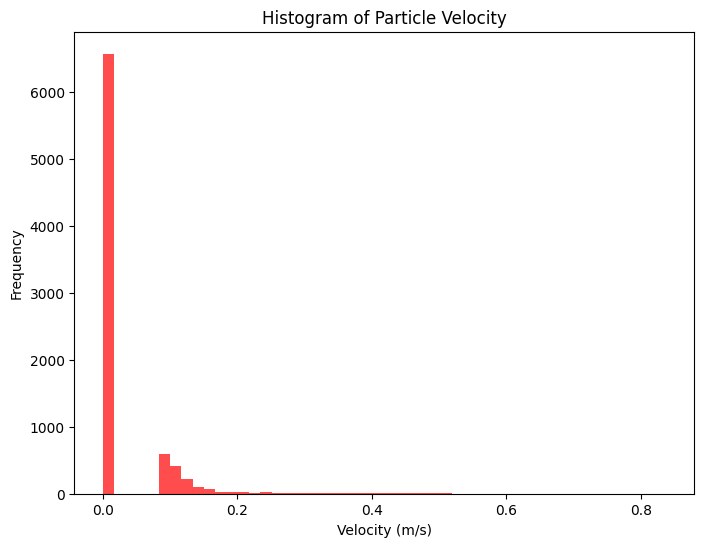

In [219]:
# Plot histogram of velocity
plt.figure(figsize=(8, 6))
plt.hist(t['velocity_um_per_s'], bins=50, color='red', alpha=0.7)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Frequency')
plt.title('Histogram of Particle Velocity')
plt.show()

## Need this

In [37]:
# Constants for conversion
pixel_to_um = 0.43  # 1 pixel = 0.43 um
time_diff = 10  # Time difference between frames in seconds

# Filter DataFrame for frames up to 150
t = t[t['frame'] <= 150]

# Determine the first and last position of each particle
first_positions = t.groupby('particle').first()[['x', 'y']]
last_positions = t.groupby('particle').last()[['x', 'y']]

# Calculate straight-line distance in pixels between first and last position
distance_pixels = np.sqrt((last_positions['x'] - first_positions['x'])**2 + 
                          (last_positions['y'] - first_positions['y'])**2)

# Convert distance to micrometers
distance_um = distance_pixels * pixel_to_um

# Calculate total time observed for each particle
total_time = (t.groupby('particle')['frame'].max() - t.groupby('particle')['frame'].min() + 1) * time_diff

# Calculate average velocity in um/s
velocity_um_per_s = distance_um / total_time

# Create a DataFrame for results
results = pd.DataFrame({
    'particle': distance_um.index,
    'total_distance_um': distance_um.values,
    'average_velocity_um_per_s': velocity_um_per_s.values
})

print(results)


     particle  total_distance_um  average_velocity_um_per_s
0           0          20.075979                   0.013295
1           1          59.668556                   0.040869
2           2          39.711501                   0.036770
3           3          47.825387                   0.031672
4           4          12.944338                   0.026417
..        ...                ...                        ...
103       103           0.000000                   0.000000
104       104           2.229837                   0.024776
105       105          12.466345                   0.155829
106       106           0.000000                   0.000000
107       107           1.553811                   0.077691

[108 rows x 3 columns]


In [38]:
# Constants for force calculation
r = 6.5 * 1e-6  # Radius of the particle in meters
eta = 2  # Viscosity of the fluid in Pa.s

# Convert velocity from um/s to m/s
results['velocity_m_per_s'] = results['average_velocity_um_per_s'] * 1e-6

# Stokes' Law to calculate force
# F = 6 * pi * eta * r * v
results['force_N'] = 6 * np.pi * eta * r * results['velocity_m_per_s']

# Display the DataFrame with calculated forces
print(results[['particle', 'average_velocity_um_per_s', 'velocity_m_per_s', 'force_N']])



     particle  average_velocity_um_per_s  velocity_m_per_s       force_N
0           0                   0.013295      1.329535e-08  3.257949e-12
1           1                   0.040869      4.086887e-08  1.001468e-11
2           2                   0.036770      3.676991e-08  9.010254e-12
3           3                   0.031672      3.167244e-08  7.761149e-12
4           4                   0.026417      2.641702e-08  6.473337e-12
..        ...                        ...               ...           ...
103       103                   0.000000      0.000000e+00  0.000000e+00
104       104                   0.024776      2.477597e-08  6.071208e-12
105       105                   0.155829      1.558293e-07  3.818507e-11
106       106                   0.000000      0.000000e+00  0.000000e+00
107       107                   0.077691      7.769057e-08  1.903763e-11

[108 rows x 4 columns]


In [39]:
top_20_forces = results.sort_values(by='force_N', ascending=False).head(20)

# Sum the forces of the top 20 particles
sum_top_20_forces = top_20_forces['force_N'].sum()

sum_top_20_forces

8.876617486915218e-10

In [227]:
r = 6.5 * 1e-6  # Radius of the particle in meters
eta = 2  # Viscosity of the fluid in Pa.s

# Convert velocity from um/s to m/s
t['velocity_m_per_s'] = t['average_velocity_um_per_s'] * 1e-6

# Stokes' Law to calculate force
# F = 6 * pi * eta * r * v
t['force_N'] = 6 * np.pi * eta * r * t['velocity_m_per_s']

# Display the DataFrame with calculated forces
print(t[['velocity_um_per_s', 'velocity_m_per_s', 'force_N']])


KeyError: 'average_velocity_um_per_s'

In [228]:
# Final cumulative force for each particle
final_cumulative_force = t.groupby('particle')['force_N'].sum().reset_index()

# Rename columns for clarity
final_cumulative_force.columns = ['Particle', 'Total_Cumulative_Force']

# Display the DataFrame with particle number and total cumulative force
final_cumulative_force


KeyError: 'Column not found: force_N'

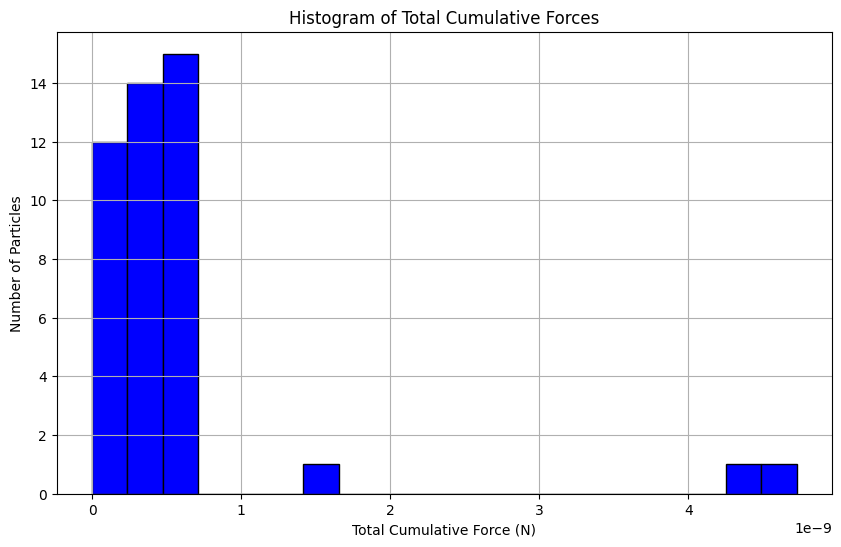

In [229]:
# Plotting a histogram of the total cumulative forces
plt.figure(figsize=(10, 6))
plt.hist(final_cumulative_force['Total_Cumulative_Force'], bins=20, color='blue', edgecolor='black')

plt.title('Histogram of Total Cumulative Forces')
plt.xlabel('Total Cumulative Force (N)')
plt.ylabel('Number of Particles')
plt.grid(True)
plt.show()

In [195]:
# Get the top 20 particles with the highest total cumulative forces
top_20_particles = final_cumulative_force.nlargest(50, 'Total_Cumulative_Force')

# Calculate the sum of the total cumulative forces of these top 20 particles
sum_top_20_forces = top_20_particles['Total_Cumulative_Force'].sum()

sum_top_20_forces


2.566301750183766e-08

In [196]:
top_20_particles

,Particle,Total_Cumulative_Force
7,7,4.726433e-09
22,23,4.487657e-09
41,46,1.522705e-09
27,29,6.728140e-10
0,0,6.409917e-10
2,2,6.303445e-10
38,40,6.108771e-10
37,39,5.843597e-10
30,32,5.808084e-10
20,21,5.455029e-10


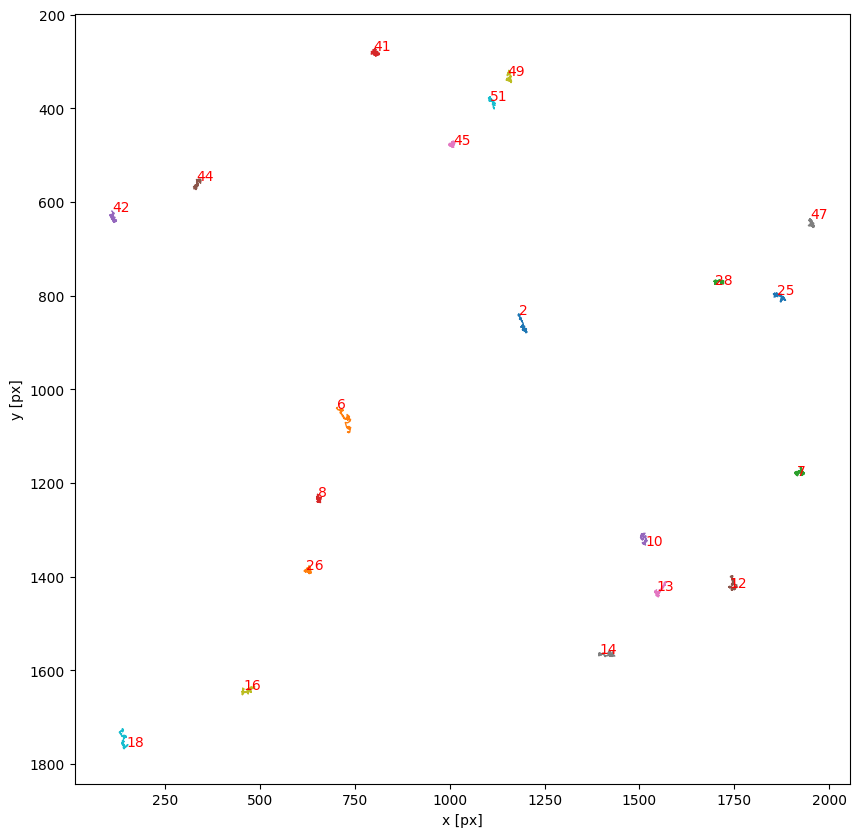

In [34]:
# Assuming 'trajectory_df' is your DataFrame with trajectory data (positions and time for each particle)
# and 'top_20_particles' contains the IDs of the top 20 particles

# Extract the particle IDs of the top 20 particles
top_20_particle_ids = top_20_particles['Particle'].tolist()

# Filter the trajectory DataFrame to include only the top 20 particles
top_20_trajectories = t[t['particle'].isin(top_20_particle_ids)]

# Plot the trajectories
def plot_trajectory_with_labels(particles_df):
    """
    This function plots the trajectories of particles and annotates each one with its ID.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    tp.plot_traj(particles_df, ax=ax)

    # Get the last position of each particle to place the text
    last_positions = particles_df.groupby('particle').last()

    # Annotate the ID of each particle
    for particle, position in last_positions.iterrows():
        ax.text(position.x, position.y, str(int(particle)), color='red')

    plt.show()

# Plotting the trajectories of the top 20 particles
plot_trajectory_with_labels(top_20_trajectories)


In [109]:
file_cumulative_forces = [
    {"aging time": 125, "Cumulative_Force_Top_20": 2.566301750183766e-08},
    {"aging time": 125, "Cumulative_Force_Top_20": 1.4707581160748883e-08},
    {"aging time": 125, "Cumulative_Force_Top_20": 1.566301750183766e-08},
    {"aging time": 65, "Cumulative_Force_Top_20": 1.9370339989580953e-19},
    {"aging time": 35, "Cumulative_Force_Top_20": 1.28831531398759e-10},
    {"aging time": 35, "Cumulative_Force_Top_20": 2.593887946986143e-10},
    {"aging time": 35, "Cumulative_Force_Top_20": 4.780097627057896e-10},
    {"aging time": 5, "Cumulative_Force_Top_20": 6.257761538139943e-11},
    {"aging time": 5, "Cumulative_Force_Top_20": 6.34643656934945e-11},
    {"aging time": 5, "Cumulative_Force_Top_20": 6.195687900415477e-11},
    {"aging time": 65, "Cumulative_Force_Top_20": 6.336386589202716e-9},
    {"aging time": 65, "Cumulative_Force_Top_20": 1.4908744661930975e-9}

    




    


    



]

cumulative_force_df = pd.DataFrame(file_cumulative_forces)


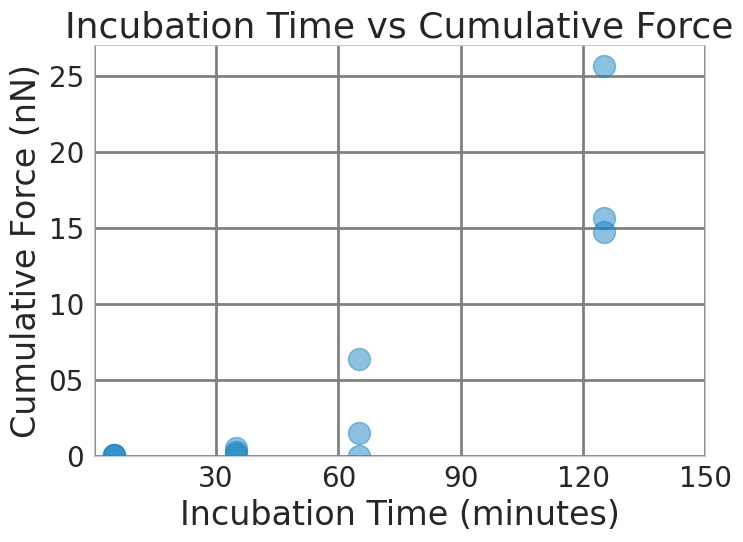

In [124]:
# Convert to DataFrame
cumulative_force_df = pd.DataFrame(file_cumulative_forces)

# Convert forces to picoNewtons (1 N = 1e9 pN)
cumulative_force_df['Cumulative_Force_Top_20'] *= 1e9

# Set the style of seaborn for prettier plots
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '-', 'grid.linewidth': 2})

# Set larger font sizes
plt.rc('font', size=26)
plt.rc('axes', titlesize=26)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=18)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(cumulative_force_df['aging time'], cumulative_force_df['Cumulative_Force_Top_20'], color='#1984c5', alpha=0.5, s=250)

# Set labels and title
ax.set_xlabel('Incubation Time (minutes)')
ax.set_ylabel('Cumulative Force (nN)')
ax.set_title('Incubation Time vs Cumulative Force')

# Set axis limits and custom ticks
ax.set_ylim(bottom=0, top=27)
ax.set_xlim(left=0, right=150)
ax.set_xticks([0, 30, 60, 90, 120, 150])
ax.set_xticklabels(['', '30', '60', '90', '120', '150'])
ax.set_yticks([0, 5, 10, 15, 20, 25])
ax.set_yticklabels(['0', '05', '10', '15', '20', '25'])
ax.grid(True, linestyle='-', linewidth=2, color='grey')

# Adjust layout
plt.tight_layout()

plt.show()


In [29]:
additional_entries = [
    {"aging time": 35, "Cumulative_Force_Top_20": sum_top_20_forces},
]


cumulative_force_df = pd.concat([cumulative_force_df, pd.DataFrame(additional_entries)], ignore_index=True)


In [30]:
cumulative_force_df

,aging time,Cumulative_Force_Top_20
0,125,5.573669e-08
1,125,6.141414e-08
2,125,5.802022e-08
3,175,5.984444e-08
4,175,5.983379e-08
5,175,6.728255e-08
6,65,3.990254e-08
7,65,5.240970e-08
8,65,3.781108e-08
9,35,5.068313e-08


In [21]:
def process_tiff_stack(file_name):
    # Open the TIFF stack
    frames = pims.open(file_name)

    # Only use bright field (bf) frames
    bf_frames = frames[::3]

    # Preprocess frames
    frames_thresh = preprocess_foam(bf_frames)

    # Extract features
    filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
    features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])

    # Tracking and calculations
    search_range = 20
    t = tp.link_df(features, search_range, memory=20)

    # Constants for conversion
    pixel_to_um = 0.43  # 1 pixel = 0.43 um
    time_diff = 10  # Time difference between frames in seconds

    # Calculate displacement and velocity
    t['dx'] = t.groupby('particle')['x'].diff()
    t['dy'] = t.groupby('particle')['y'].diff()
    t['displacement_pixels'] = np.sqrt(t['dx']**2 + t['dy']**2)
    t['displacement_um'] = t['displacement_pixels'] * pixel_to_um
    t['velocity_um_per_s'] = t['displacement_um'] / time_diff
    t.drop(['dx', 'dy', 'displacement_pixels'], axis=1, inplace=True)

    # Constants for force calculation
    r = 6.5 * 1e-6  # Radius in meters
    eta = 2  # Viscosity in Pa.s

    # Calculate force
    t['velocity_m_per_s'] = t['velocity_um_per_s'] * 1e-6
    t['force_N'] = 6 * np.pi * eta * r * t['velocity_m_per_s']

    return t



In [22]:
# Define the function in this cell
def process_single_file(file):
    file_path = os.path.join(base_dir, file)
    return file, process_tiff_stack(file_path)


In [95]:
base_dir = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_2/stokes/'

# Scan for TIFF files in the directory
tiff_files = [f for f in os.listdir(base_dir) if f.endswith('.tif') or f.endswith('.tiff')]

# Process each TIFF stack and compile results
all_results = {}
for file in tiff_files:
    file_path = os.path.join(base_dir, file)
    all_results[file] = process_tiff_stack(file_path)

# Combine all results into a single DataFrame
combined_results = pd.concat(all_results, names=['file_name', 'index'])

# Save the combined DataFrame
combined_results.to_csv('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_2/stokes/combined_results.csv')

Frame 166: 38 trajectories present.


In [96]:
combined_results

y            x  frame  particle  \
file_name          index                                              
5_6.1_65_min_1.tif 0        23.352227     7.728745      0         0   
                   24     1766.083548  1048.681234      0         1   
                   23     1633.861461   196.904282      0         2   
                   22     1631.933248   480.757381      0         3   
                   21     1525.763359  1969.907125      0         4   
...                               ...          ...    ...       ...   
5_6.1_5_min_3.tif  5718    557.212471   189.182448    166        56   
                   5719    678.603846   381.238462    166        39   
                   5720    682.702247  1499.411985    166        13   
                   5712    414.445269   577.656772    166        46   
                   5742   1975.286942  1800.529210    166        33   

                          displacement_um  velocity_um_per_s  \
file_name          index                                       
5_6.1_65_min_1.tif 0                  NaN                NaN   
                   24                 NaN                NaN   
                   23                 NaN                NaN   
                   22                 NaN                NaN   
                   21                 NaN                NaN   
...                                   ...                ...   
5_6.1_5_min_3.tif  5718          1.550393           0.155039   
                   5719          1.580302           0.158030   
                   5720          0.299532           0.029953   
                   5712          0.603301           0.060330   
                   5742          0.753812           0.075381   

                          velocity_m_per_s       force_N  
file_name          index                                  
5_6.1_65_min_1.tif 0                   NaN           NaN  
                   24                  NaN           NaN  
                   23                  NaN           NaN  
                   22                  NaN           NaN  
                   21                  NaN           NaN  
...                                    ...           ...  
5_6.1_5_min_3.tif  5718       1.550393e-07  3.799148e-11  
                   5719       1.580302e-07  3.872438e-11  
                   5720       2.995322e-08  7.339864e-12  
                   5712       6.033010e-08  1.478354e-11  
                   5742       7.538124e-08  1.847174e-11  

[20269 rows x 8 columns]

In [97]:
# Create a list to hold file names and their corresponding average forces
average_forces_data = []

# Iterate over each experiment (file) and calculate the average force
for file, data in all_results.items():
    avg_force = data['force_N'].mean()
    average_forces_data.append({'file_name': file, 'average_force': avg_force})

# Convert the list of dictionaries to a DataFrame
average_forces_df = pd.DataFrame(average_forces_data)

# Display the DataFrame
print(average_forces_df)

              file_name  average_force
0    5_6.1_65_min_1.tif            NaN
1    5_6.1_65_min_3.tif            NaN
2    5_6.1_65_min_2.tif            NaN
3   5_6.1_125_min_3.tif            NaN
4    5_6.1_35_min_3.tif            NaN
5   5_6.1_125_min_2.tif            NaN
6    5_6.1_35_min_2.tif            NaN
7    5_6.1_35_min_1.tif            NaN
8   5_6.1_125_min_1.tif            NaN
9     5_6.1_5_min_1.tif   1.151596e-11
10    5_6.1_5_min_2.tif   1.588772e-11
11    5_6.1_5_min_3.tif   1.567078e-11


In [7]:
# Path to the specific CSV file
csv_file_path = '/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_2/stokes/combined_results.csv'
# Read the CSV file into a DataFrame
combined_results = pd.read_csv(csv_file_path)

# Split the DataFrame by 'file_name'
grouped_by_file = combined_results.groupby('file_name')

# Initialize a dictionary to store the count of particles that moved more than 10um for each file
particles_moved_count = {}

# Iterate over each group (file)
for file_name, group in grouped_by_file:
    # Sum the displacement for each particle in this file
    total_displacement_per_particle = group.groupby('particle')['displacement_um'].sum()
    
    # Count the number of particles that moved more than 10um
    count = (total_displacement_per_particle > 10).sum()
    
    # Store the count in the dictionary
    particles_moved_count[file_name] = count

# Convert the dictionary to a DataFrame
particles_moved_more_than_10um_df = pd.DataFrame(list(particles_moved_count.items()), columns=['Experiment', 'Particles_Moved_More_Than_10um'])

# Display the DataFrame
particles_moved_more_than_10um_df.head()


,Experiment,Particles_Moved_More_Than_10um
0,5_6.1_125_min_1.tif,0
1,5_6.1_125_min_2.tif,0
2,5_6.1_125_min_3.tif,0
3,5_6.1_35_min_1.tif,0
4,5_6.1_35_min_2.tif,0


In [9]:
csv_file_path = '/home/shichenliu/Dropbox/Academics/PhD_phase/Thomson_Lab/local_to_global_pre-print/data/figure_2/stokes/combined_results.csv'


# Read the CSV file into a DataFrame
combined_results = pd.read_csv(csv_file_path)

# Split the DataFrame by 'file_name'
grouped_by_file = combined_results.groupby('file_name')

# Initialize a dictionary to store the count of particles that moved more than 10um for each file
particles_moved_count = {}

# Iterate over each group (file)
for file_name, group in grouped_by_file:
    # Sum the displacement for each particle in this file
    total_displacement_per_particle = group.groupby('particle')['displacement_um'].sum()
    
    # Count the number of particles that moved more than 10um
    count = (total_displacement_per_particle > 10).sum()
    
    # Store the count in the dictionary
    particles_moved_count[file_name] = count

# Convert the dictionary to a DataFrame
particles_moved_more_than_10um_df = pd.DataFrame(list(particles_moved_count.items()), columns=['Experiment', 'Particles_Moved_More_Than_10um'])

# Display the DataFrame
particles_moved_more_than_10um_df.head()


,Experiment,Particles_Moved_More_Than_10um
0,5_6.1_125_min_1.tif,0
1,5_6.1_125_min_2.tif,0
2,5_6.1_125_min_3.tif,0
3,5_6.1_35_min_1.tif,0
4,5_6.1_35_min_2.tif,0


In [10]:
# Read the CSV file into a DataFrame
combined_results = pd.read_csv(csv_file_path)

# Calculate cumulative displacement for each particle in each experiment
combined_results['cumulative_displacement'] = combined_results.groupby(['file_name', 'particle'])['displacement_um'].cumsum()

# Filter out the last occurrence of each particle in each experiment to get its final cumulative displacement
final_displacements = combined_results.drop_duplicates(subset=['file_name', 'particle'], keep='last')

# For each experiment, find the particle that moved the furthest
furthest_moved_particles = final_displacements.loc[final_displacements.groupby('file_name')['cumulative_displacement'].idxmax()]

# Display the results
furthest_moved_particles[['file_name', 'particle', 'cumulative_displacement']]

/tmp/ipykernel_783387/4104665861.py:11: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  furthest_moved_particles = final_displacements.loc[final_displacements.groupby('file_name')['cumulative_displacement'].idxmax()]
/tmp/ipykernel_783387/4104665861.py:11: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  furthest_moved_particles = final_displacements.loc[final_displacements.groupby('file_name')['cumulative_displacement'].idxmax()]
/tmp/ipykernel_783387/4104665861.py:11: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  furthest_moved_particles = final_displacements.loc[final_displacements.groupby('file_name')['cumulative_displacement'].idxmax()]
/tmp/ipykernel_783387/

KeyError: '[nan] not in index'

,file_name,particle,cumulative_displacement
327,5_6.1_125_min_1.tif,0,0.000000
176,5_6.1_125_min_2.tif,0,0.000000
86,5_6.1_125_min_3.tif,0,0.000000
275,5_6.1_35_min_1.tif,0,0.000000
226,5_6.1_35_min_2.tif,0,0.000000
135,5_6.1_35_min_3.tif,0,0.000000
8729,5_6.1_5_min_1.tif,2,116.884616
13981,5_6.1_5_min_2.tif,7,231.952987
19159,5_6.1_5_min_3.tif,29,214.928958
0,5_6.1_65_min_1.tif,0,0.000000
